**Name: Deep Modi**

**En No: 18012011016**

**Subject: Deep Learning**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
from skimage import io
from skimage.transform import  resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [6]:
from os import listdir
import shutil
import os

In [7]:
train_csv = "/content/drive/MyDrive/Dl_Project/train.csv"
test_csv = "/content/drive/MyDrive/Dl_Project/test.csv"
train_image_path = "/content/drive/MyDrive/Dl_Project/train"
test_image_path = "/content/drive/MyDrive/Dl_Project/test"


In [8]:
train_df_img_list = pd.read_csv(  train_csv, sep = "," )
test_df_img_list =  pd.read_csv(  test_csv, sep = "," )

In [9]:
train_df_img_list.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


Text(0, 0.5, 'Count')

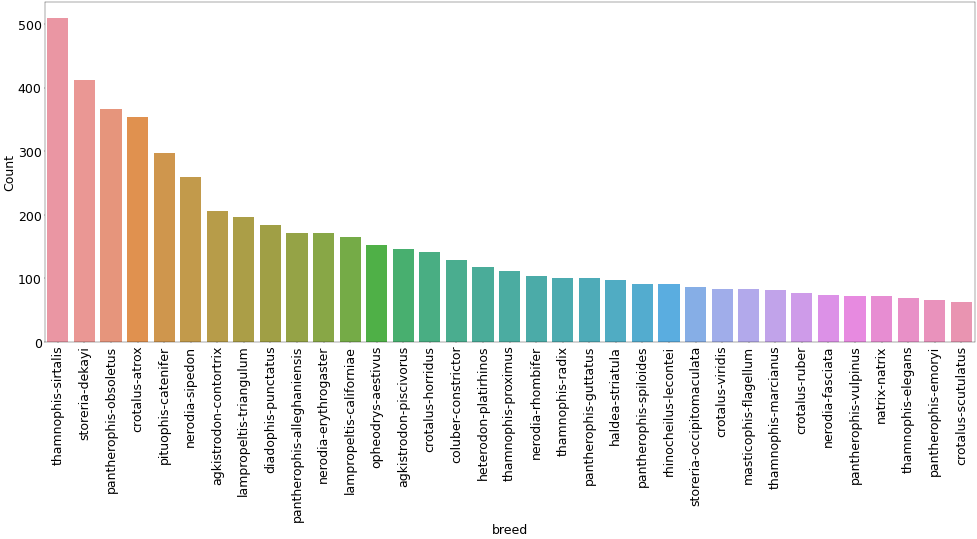

In [10]:
fig = plt.figure( figsize = (40,15), dpi = 30)
sns.countplot( data = train_df_img_list, x = "breed", order = train_df_img_list["breed"].value_counts() .index )
plt.xticks( rotation = 90, fontsize = 30 )
plt.yticks( fontsize = 30)
plt.xlabel ("breed", fontsize = 30)
plt.ylabel( "Count", fontsize = 30)

In [11]:
print ( "Number of class =", len( train_df_img_list["breed"].unique())  )

Number of class = 35


In [13]:
''' Creating Data generator '''
def image_read ( path, img_width = 100,img_height = 100 ):
    
    data = io.imread( path)
    return (resize(data/ 255,(img_width, img_height) ) )

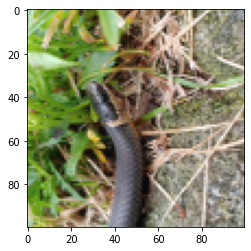

In [14]:
file_list = os.listdir(train_image_path)
plt.imshow ( image_read ( path = train_image_path +"/"+file_list[0],
                        img_width = 100,
                        img_height = 100)
           )

## Data generator, each call will spits out data to save memory

In [15]:
def data_generator( train_file_name , path, img_height = 100, img_width = 100, batch_size = 300, cat_col = "breed", image_col ="image_id", file_format = ".jpg" ):
    
    df = shuffle( pd.read_csv(train_file_name, sep =",") )
    unique_breed  = list ( df[cat_col].unique() )
    
    while True:
        
        for each_chunk in pd.read_csv(train_file_name, chunksize=batch_size, sep =","):

            data  = np.zeros ( ( each_chunk.shape[0] , img_width, img_height, 3 )   )
            label = np.zeros ( ( each_chunk.shape [0]  , len(unique_breed) )  ) 

            each_chunk= shuffle ( each_chunk )

            for each_row in range( each_chunk.shape[0] ):

                each_image =  path +"/"+ each_chunk.iloc[each_row][0] + file_format

                each_breed =  each_chunk.iloc[each_row][1]

                each_image_data = image_read (path = each_image, img_width = img_width ,img_height = img_height  )

                data[each_row, :, :, 0 ] =  each_image_data[:,:,0]/255

                data[each_row, :, :, 1 ] =  each_image_data[:,:,1]/255

                data[each_row, :, :, 2 ] =  each_image_data[:,:,2]/255

                label[each_row,unique_breed.index(each_breed) ] =  1

            yield ( data, label )

Starting to build model

In [16]:
''' Required Tensorflow library for preocessing '''
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing
import tensorflow as tf

In [17]:
img_width = 90
img_height = 90
batch_size = 1000
number_of_channel = 3 # RGB
number_of_class = train_df_img_list["breed"].unique()
if ( train_df_img_list.shape[0] % batch_size ) ==0 :
    
    steps_per_epoch = int( train_df_img_list.shape[0]/batch_size)
    
else:
    steps_per_epoch = (train_df_img_list.shape[0] //batch_size ) + 1
    
np.random.random(30)
tf.random.set_seed(30)

train_data_with_label = data_generator(train_file_name = train_csv , 
                            path =train_image_path, 
                            img_height = img_height, 
                            img_width = img_width, 
                            batch_size = batch_size, 
                            cat_col = "breed", 
                            image_col ="image_id", 
                            file_format = ".jpg" )


In [18]:
cnn_model = Sequential()

cnn_model.add ( Conv2D ( filters = 16, kernel_size = (2,2), strides = (1,1), padding = "valid",activation ="relu", input_shape = ( img_width,img_height, number_of_channel  ) ) )
cnn_model.add (Conv2D  ( filters = 32, kernel_size = (2,2), strides = (2,2), padding = "valid",activation = "elu" )  )
cnn_model.add (Conv2D  ( filters = 32, kernel_size = (2,2), strides = (1,1), padding = "valid",activation = "elu" )  )
cnn_model.add (Dropout(0.2))

cnn_model.add (Conv2D  ( filters = 32, kernel_size = (2,2), strides = (2,2), padding = "valid",activation = "elu" )  )
cnn_model.add (Dropout(0.2))
cnn_model.add (Conv2D  ( filters = 32, kernel_size = (2,2), strides = (2,2), padding = "valid",activation = "elu" )  )
#cnn_model.add (Conv2D  ( filters = 64, kernel_size = (2,2), strides = (1,1), padding = "valid",activation = "elu" )  )
cnn_model.add ( Flatten() )
cnn_model.add ( Dense (units = 128, activation = "relu",use_bias = True  ) )
cnn_model.add (Dropout(0.2))
cnn_model.add ( Dense (units = 64, activation = "relu",use_bias = True  ) )
cnn_model.add (Dropout(0.1))
cnn_model.add ( Dense (units = 35, activation = "softmax",use_bias = False  ) )
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 89, 89, 16)        208       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 32)        4128      
                                                                 
 dropout (Dropout)           (None, 43, 43, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 32)        4128      
                                                                 
 dropout_1 (Dropout)         (None, 21, 21, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 32)        4

In [19]:
cnn_model.compile (optimizer= "adam", loss = "categorical_crossentropy" , metrics = ["categorical_accuracy"] )

In [20]:
cnn_model.fit_generator(  train_data_with_label, steps_per_epoch=steps_per_epoch,epochs = 10, shuffle=  True ) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
6/6 [==============================] - 82s 13s/step - loss: 3.5130 - categorical_accuracy: 0.0674
Epoch 2/10
6/6 [==============================] - 85s 13s/step - loss: 3.4487 - categorical_accuracy: 0.0753
Epoch 3/10
6/6 [==============================] - 86s 14s/step - loss: 3.4202 - categorical_accuracy: 0.0775
Epoch 4/10
6/6 [==============================] - 84s 13s/step - loss: 3.3994 - categorical_accuracy: 0.0815
Epoch 5/10
6/6 [==============================] - 88s 14s/step - loss: 3.3900 - categorical_accuracy: 0.0882
Epoch 6/10
6/6 [==============================] - 87s 14s/step - loss: 3.3864 - categorical_accuracy: 0.0830
Epoch 7/10
6/6 [==============================] - 88s 14s/step - loss: 3.3844 - categorical_accuracy: 0.0861
Epoch 8/10
6/6 [==============================] - 88s 14s/step - loss: 3.3782 - categorical_accuracy: 0.0862
Epoch 9/10
6/6 [==============================] - 87s 14s/step - loss: 3.3760 - categorical_accuracy: 0.0877
Epoch 10/10
6/6 [==

In [21]:
steps_per_epoch

6